# Metric Analysis - Part:2

### Overview

Broadly we have 3 types of Analytics -

1. **Descriptive Analytics**
2. **Predictive Analytics**
3. **Prescriptive Analytics**

In this notebook, we focus on the **Predictive Analytics** part.

The purpose of this notebook is to predict input metric using Seasonal Arima (SARIMA).

### Style &  Libraries

In [473]:
%matplotlib inline

# CSS File
from IPython.core.display import HTML
from IPython.display import Image

# Libraries
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as npb
import pandas as pd
import pandas_datareader as pdr
import pandas_datareader.data as web
import datetime as dt
from matplotlib.dates import DayLocator, HourLocator, MinuteLocator, AutoDateLocator, DateFormatter
from seasonal import fit_seasons, adjust_seasons, fit_trend

import seaborn as sns
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# Style Setting
sns.set(style="ticks", color_codes=True)
sns.set_context("notebook")
sns.set_style("darkgrid")

# Notebook Style Setting
css = open('styles/style-table.css').read() + open('styles/style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [475]:
def read_metric_data(metric_name, csv_name):
    '''
        Read metric data from a given csv file.
        CSV format: [server_name, timestamp, value]
        Timestamp format: YYYY-MM-DD HH:mm:SS
        Lines begining with # are ignored as comments.
    '''
    
    # Read from csv file.
    df = pd.read_csv(csv_name, index_col=1, parse_dates=True, names=[ 'server', 'value'], comment='#', quotechar="'", sep=",")
    if(df.isnull().value.any()): 
        #print ("{0} - missing data row count#: {1}".format(csv_name, np.count_nonzero(df1.isnull().values)))
        df = df.fillna(method='ffill', limit=2) # Fill last value upto two consequtive slots
        
    #print("{0} - #Observations: {1}".format(csv_name, df.shape))
    return df

def describe_metric(metric_name, df):
    '''
        Generate custom summary of the data
    '''
    summary = df.describe(percentiles=[0.05,0.25,0.5,0.75,0.95])
    summary.columns = [metric_name]
    summary = summary.applymap('{:.2f}'.format) # URL: https://pyformat.info/
    #summary['value'] = summary['value'].map('{:.2f}'.format) 
    #summary.drop(labels=['count'], axis=0, inplace=True)
    summary.loc['frequent'] = df.mode().value[0]
    summary.loc['skewness'] = df.value.skew()
    summary.loc['kurtosis'] = "{0:.2f}".format(round(df.value.kurtosis(), 2))
    summary = summary.rename(index={'count': 'samples', 'mean':'average', 'std':'std dev', 'min':'lowest', 'max':'highest'})
    return summary

def create_line_plot(metric_name, series):
    '''
        Create line plot using seaborn
    '''
    # Create line chart
    fig = plt.figure(figsize=(12, 5))
    ax = plt.gca()
    ax.xaxis.set_major_locator(HourLocator(interval=6))
    ax.xaxis.set_major_formatter(DateFormatter('%m/%d %I:%M %p')) # TimeFormat : http://strftime.org/
    plt.plot(series, color='steelblue')
    #plt.xlabel("timestamp", fontweight='bold')
    plt.ylabel(metric_name, fontweight='bold')
    plt.gcf().autofmt_xdate()
    return

def test_stationarity(timeseries, window=24):
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=24,center=False).mean() # pd.rolling_mean(timeseries, window=window)
    rolstd = timeseries.rolling(window=24,center=False).std() #pd.rolling_std(timeseries, window=window)

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 4))
    orig = plt.plot(timeseries, color='steelblue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    return

def dickey_fuller_test(timeseries):
    #Perform Dickey-Fuller test:
    print 'Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags','Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput 
    return

In [ ]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Toggle Code On/Off"></form>''')

### Configuration

In [476]:
metric_name = "Disk Utilization (%)"
csv_name = 'data/du_7d.txt'

print("metric_name:\t{0}, \ndata_filename:\t{1}".format(metric_name, csv_name))

metric_name:	Disk Utilization (%), 
data_filename:	data/du_7d.txt


### Approach

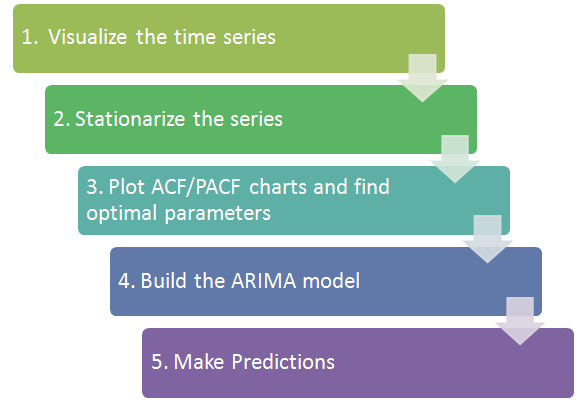

In [477]:
Image(filename='images/arima-flowchart.png', width=500,height=500)

### 1. Visualize the Data

In [478]:
# Load data
df1 = read_metric_data(metric_name, csv_name)
df1.value = df1.value.round(3)

# Create Summary
summary = describe_metric(metric_name, df1)
summary.T

,samples,average,std dev,lowest,5%,25%,50%,75%,95%,highest,frequent,skewness,kurtosis
Disk Utilization (%),168.00,0.11,0.01,0.10,0.10,0.11,0.11,0.11,0.13,0.16,0.107,3.01926,10.34


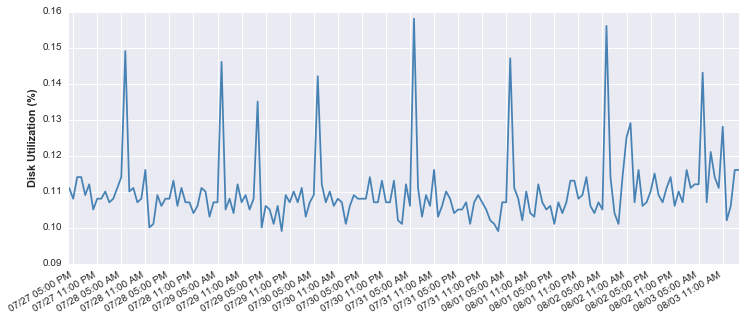

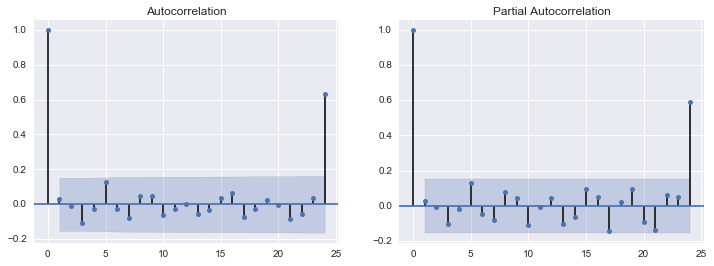

In [479]:
# Graph line plot
create_line_plot(metric_name, df1.value)

# Graph ACF & PACF
fig, axes = plt.subplots(1, 2, figsize=(12,4))
fig = sm.graphics.tsa.plot_acf(df1.ix[1:, 'value'], lags=24, ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(df1.ix[1:, 'value'], lags=24, ax=axes[1])

### 2. Stationarize the Data


 Actual data:


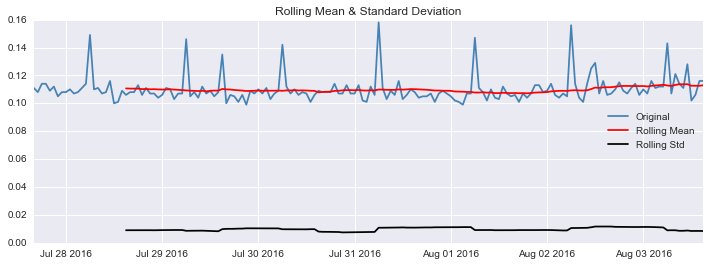

Dickey-Fuller Test:
Test Statistic         -1.244982e+01
p-value                 3.596225e-23
#Lags                   0.000000e+00
Observations Used       1.670000e+02
Critical Value (5%)    -2.879008e+00
Critical Value (1%)    -3.470126e+00
Critical Value (10%)   -2.576083e+00
dtype: float64


In [480]:
df = df1.copy()

print('\n Actual data:')
test_stationarity(df.value)
dickey_fuller_test(df.value)

First Diff Transformation:
---------------------------


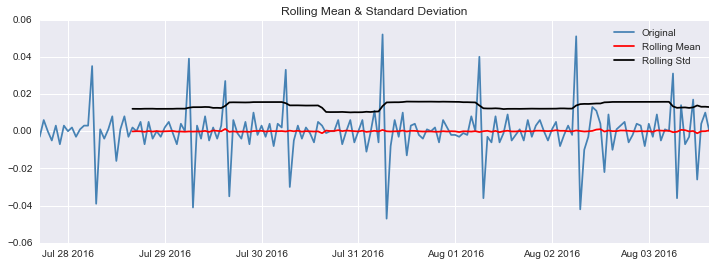

Dickey-Fuller Test:
Test Statistic         -8.110504e+00
p-value                 1.229537e-12
#Lags                   7.000000e+00
Observations Used       1.590000e+02
Critical Value (5%)    -2.879895e+00
Critical Value (1%)    -3.472161e+00
Critical Value (10%)   -2.576557e+00
dtype: float64

Seasonal Diff Transformation:
---------------------------


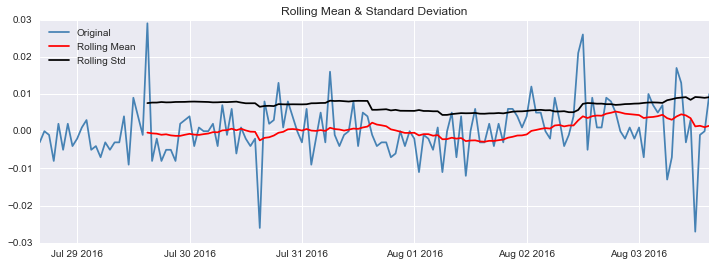

Dickey-Fuller Test:
Test Statistic           -4.394311
p-value                   0.000304
#Lags                     4.000000
Observations Used       139.000000
Critical Value (5%)      -2.882568
Critical Value (1%)      -3.478294
Critical Value (10%)     -2.577983
dtype: float64


In [481]:
# Let's eliminate the trend from the data and see if it helps on stationarity. 
print('First Diff Transformation:\n---------------------------')
df['first_diff'] = df.value - df.value.shift(1)
df.first_diff.dropna(inplace=True)
test_stationarity(df.first_diff)
dickey_fuller_test(df.first_diff)

# Lets eliminate seasonality and see if it helps on stationarity
print('\nSeasonal Diff Transformation:\n---------------------------')
df['seasonal_diff'] = df.value - df.value.shift(24)
df.seasonal_diff.dropna(inplace=True)
test_stationarity(df.seasonal_diff)
dickey_fuller_test(df.seasonal_diff)

### 3. Plot ACF & PACF Graphs

Plotting acf and pacf graphs for transformations...


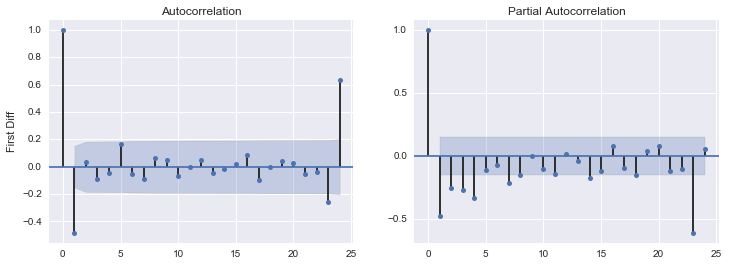

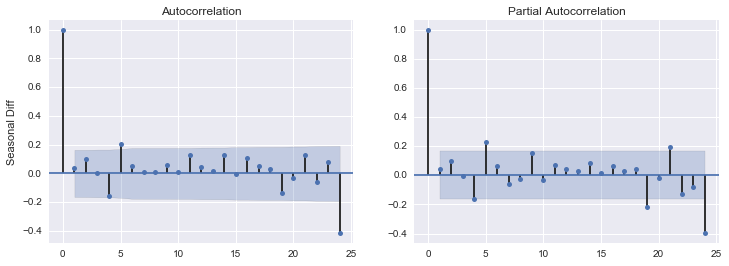

In [482]:
print("Plotting acf and pacf graphs for transformations...")

# Graph ACF & PACF
fig, axes = plt.subplots(1, 2, figsize=(12,4))
fig = sm.graphics.tsa.plot_acf(df.ix[1:, 'first_diff'], lags=24, ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(df.ix[1:, 'first_diff'], lags=24, ax=axes[1])
axes[0].set(ylabel='First Diff')

# Graph ACF & PACF
fig, axes = plt.subplots(1, 2, figsize=(12,4))
fig = sm.graphics.tsa.plot_acf(df.ix[1:, 'seasonal_diff'], lags=24, ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(df.ix[1:, 'seasonal_diff'], lags=24, ax=axes[1])
axes[0].set(ylabel='Seasonal Diff')

### 4. Build Model

In [483]:
print("Building model with Seasonal ARIMA...\n")
# We need seasonal ARIMA model given the data has seasonality (i.e., every 24 hours)
mod = sm.tsa.statespace.SARIMAX(df.value, trend='n', order=(1,1,0), seasonal_order=(1,0,1,24), 
                                enforce_stationarity=True, enforce_invertibility=True)
results = mod.fit()
print results.summary()

Building model with Seasonal ARIMA...

                                 Statespace Model Results                                 
Dep. Variable:                              value   No. Observations:                  168
Model:             SARIMAX(1, 1, 0)x(1, 0, 1, 24)   Log Likelihood                 583.733
Date:                            Tue, 09 Aug 2016   AIC                          -1159.467
Time:                                    12:18:24   BIC                          -1146.971
Sample:                                07-27-2016   HQIC                         -1154.395
                                     - 08-03-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4959      0.052     -9.558      0.000      -0.598      -0.

### 5. Forecast Results

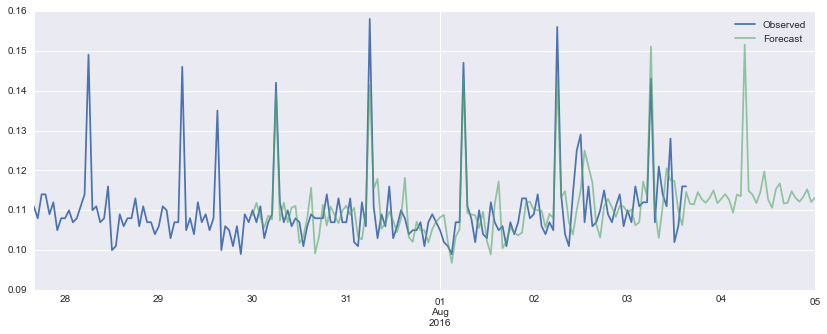

In [484]:
# Fit the model
forecast = results.predict('2016-07-30','2016-08-5', typ='levels')
ax = df['value'].plot(label='Observed', figsize=(14,5))
forecast.plot(ax=ax, label='Forecast', alpha=.6)
plt.legend()
sns.despine()